In [1]:
# %pip install -r requirements.txt
# %/Applications/Python\ 3.11/Install\ Certificates.command
# %pip install git+https://github.com/tensorflow/examples.git
# !python3 -m pip install --upgrade pip

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam


2024-10-09 22:11:55.819333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def load_images_from_folder(folders):
    files = [f for folder in folders for f in os.listdir(f'data/{folder}/images')]
    return tf.data.Dataset.from_tensor_slices(files)

In [4]:
validation_data = load_images_from_folder(['valid'])
training_data = load_images_from_folder(['train', 'test'])
# testing_data = load_images_from_folder(['test'])

In [5]:
train_length = len(training_data)
validation_length = len(validation_data)
print(f'train_length: {train_length}')
batch_size = 64
learning_rate = 0.001
buffer_size = 3000
steps_per_epoch = train_length // batch_size
image_size = (640, 640)
id_multiplier = 64 # This makes the segmentation mask more human-readable, see data_processing.ipynb
use_different_classes_for_windows_and_solar_panels = False # If True, the model will have 4 output channels, otherwise 2, see data_processing.ipynb
output_channels = 4 if use_different_classes_for_windows_and_solar_panels else 2
seed = 420
epochs = 64
model_version = 'v0_6'

train_length: 1218


- v0_1: initial training, verify the model
- v0_2: initial training
- v0_3: training with tuned hyperparameters on open source dataset
- v0_4: training with tuned hyperparameters on scopr dataset (with bad data)
- v0_4b: training with tuned hyperparameters on scopr dataset (with bad data)
- v0_4c: training with tuned hyperparameters on scopr dataset (with good data), but one epoch (tf 2.15.1)
- v0_5: training with tuned hyperparameters on scopr dataset (with good data), multiple epochs (tf 2.15.1)
- v0_5b: training with improved training on scopr dataset (with good data), multiple epochs, diminishing learning rate and early stopping (tf 2.15.1) (batch_size 16, learning rate 0.004 > 10 / 2)

In [6]:
# Normalize the images to [0, 1]
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.cast(input_mask, tf.float32) / id_multiplier
  return input_image, input_mask

def parse_image_and_label(image_path, label_path):
    # Read the image and label files
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    label = tf.io.read_file(label_path)
    label = tf.image.decode_jpeg(label, channels=1) # Labels are grayscale

    # Preprocess the images and labels
    image = tf.image.resize(image, image_size)
    label = tf.image.resize(label, image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image, label = normalize(image, label)

    return image, label

def create_dataset(data_dir):
    image_dir = os.path.join(data_dir, 'images')
    label_dir = os.path.join(data_dir, 'labels')
    
    # Assuming file names are the same for images and labels
    image_file_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    label_file_paths = sorted([os.path.join(label_dir, fname[:-4] + '.png') for fname in os.listdir(label_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((image_file_paths, label_file_paths))
    dataset = dataset.map(parse_image_and_label)
    
    return dataset

# Create the datasets
train_images = create_dataset('data/train')
test_images = create_dataset('data/test')
validation_images = create_dataset('data/valid')


In [7]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels


In [8]:
train_batches = (
    train_images
    .cache()
    .shuffle(buffer_size, seed=seed)
    .batch(batch_size)
    .repeat()
    # .map(Augment(seed=seed)) # Optional, augment the data. Currently already done in the data
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(batch_size)


In [9]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


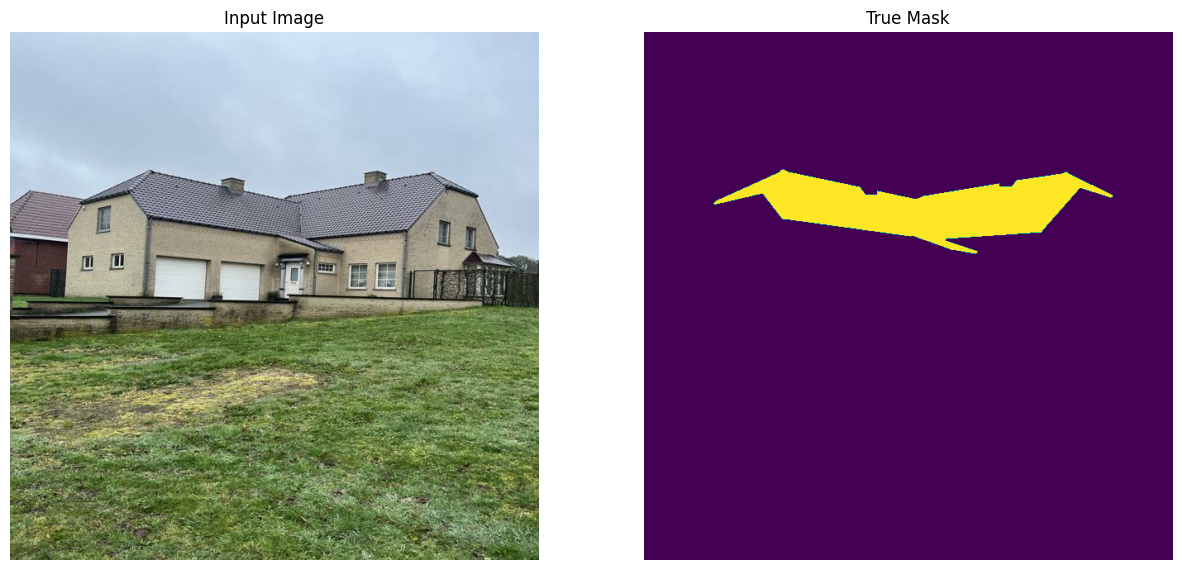

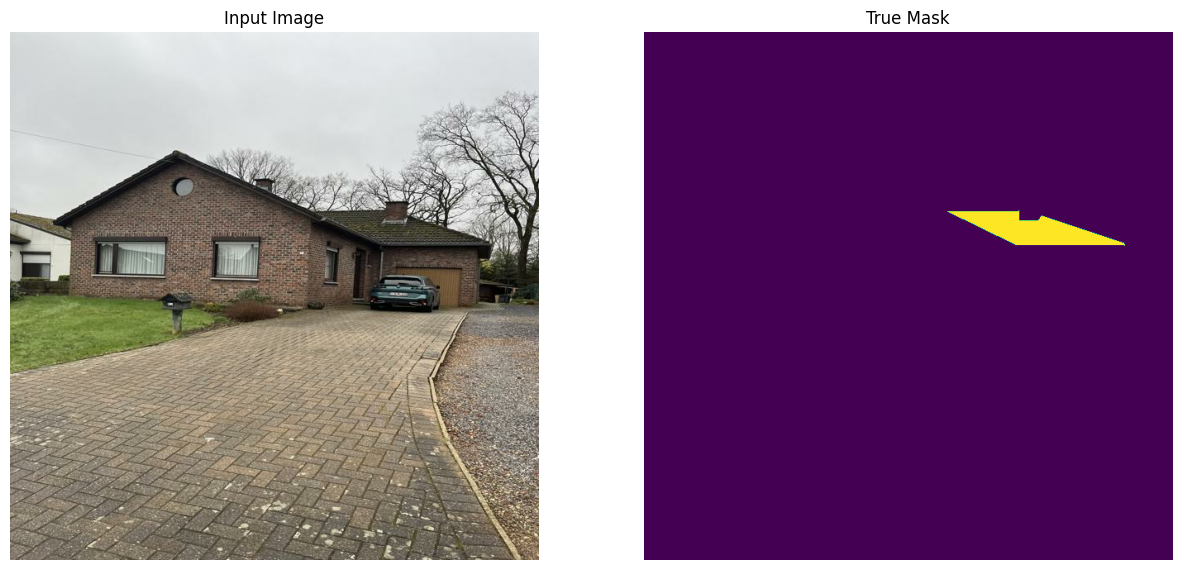

In [10]:
for image, mask in train_images.take(2):
  sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[image_size[0], image_size[1], 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # Higher resolution features
    'block_3_expand_relu',   # ↓
    'block_6_expand_relu',   # ↓
    'block_13_expand_relu',  # Medium resolution features
    'block_16_project',      # Lower resolution, deeper features
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


In [12]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]


In [13]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[image_size[0], image_size[1], 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    # print(x.shape, skip.shape)
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [14]:
model = unet_model(output_channels=output_channels)

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [15]:
# tf.keras.utils.plot_model(model)


In [16]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [17]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


1/1 [==============================] - 1s 1s/step


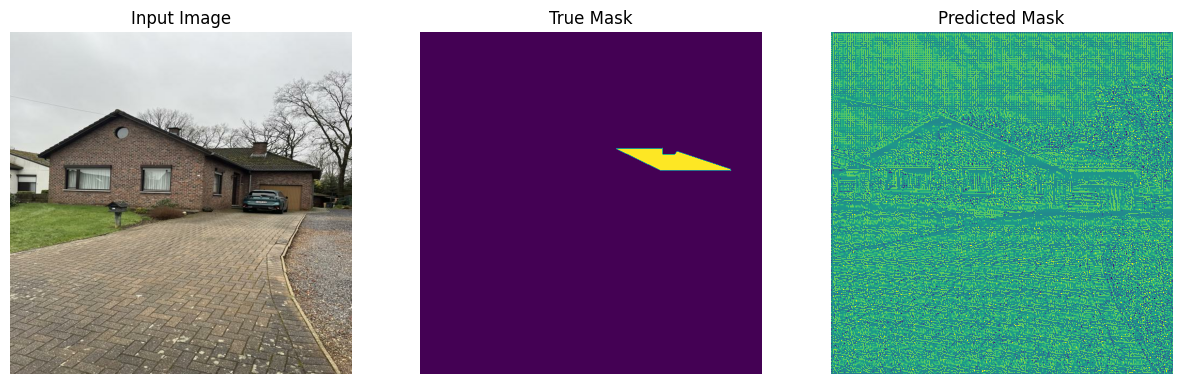

In [18]:
show_predictions()


In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


In [20]:
def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.5 
    return lr

1/1 [==============================] - 0s 463ms/step


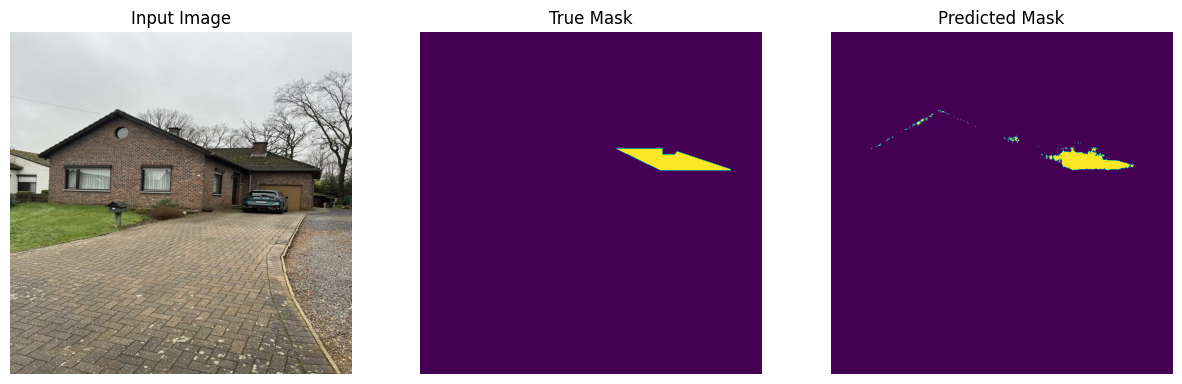


Sample Prediction after epoch 17

19/19 [==============================] - 1066s 56s/step - loss: 0.0478 - accuracy: 0.9816 - val_loss: 0.0335 - val_accuracy: 0.9868 - lr: 1.5625e-05


In [21]:
validation_subsplits = 3
validation_steps = validation_length//batch_size//validation_subsplits

lr_scheduler = LearningRateScheduler(lr_schedule)

checkpoint = ModelCheckpoint(filepath='best_model.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_history = model.fit(train_batches, epochs=epochs,
                          steps_per_epoch=steps_per_epoch,
                          validation_steps=validation_steps,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(), lr_scheduler, checkpoint, early_stopping])


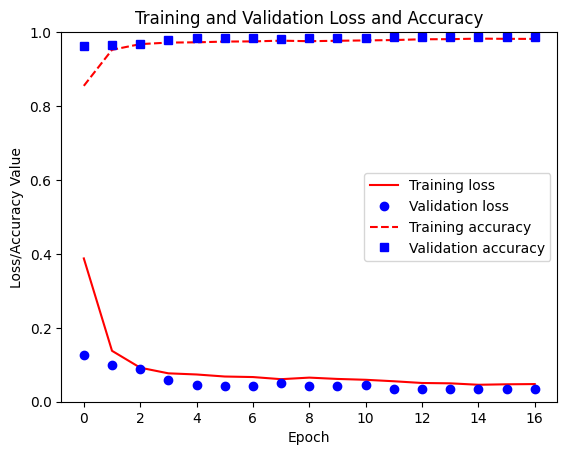

In [22]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

if len(val_loss) < len(loss):
    val_loss += [val_loss[-1]] * (len(loss) - len(val_loss))
if len(val_accuracy) < len(accuracy):
    val_accuracy += [val_accuracy[-1]] * (len(accuracy) - len(val_accuracy))

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.plot(model_history.epoch, accuracy, 'r--', label='Training accuracy')
plt.plot(model_history.epoch, val_accuracy, 'bs', label='Validation accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


1/1 [==============================] - 0s 403ms/step


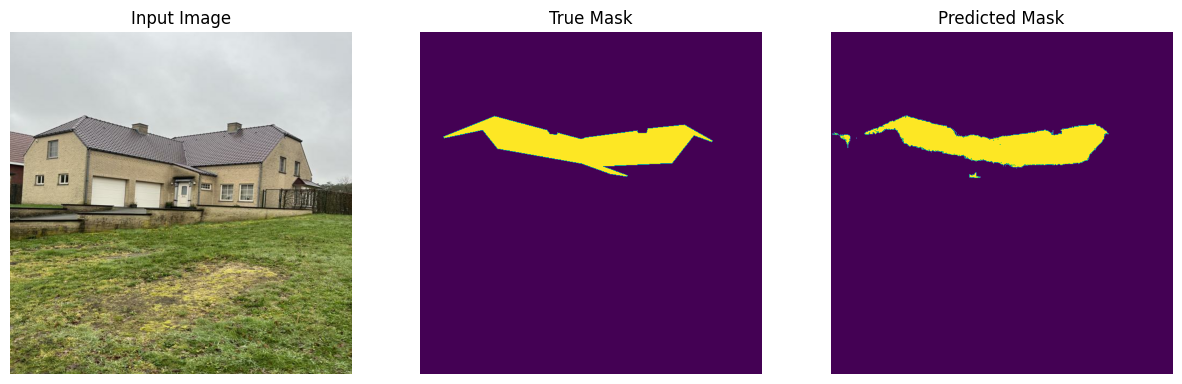

1/1 [==============================] - 0s 383ms/step


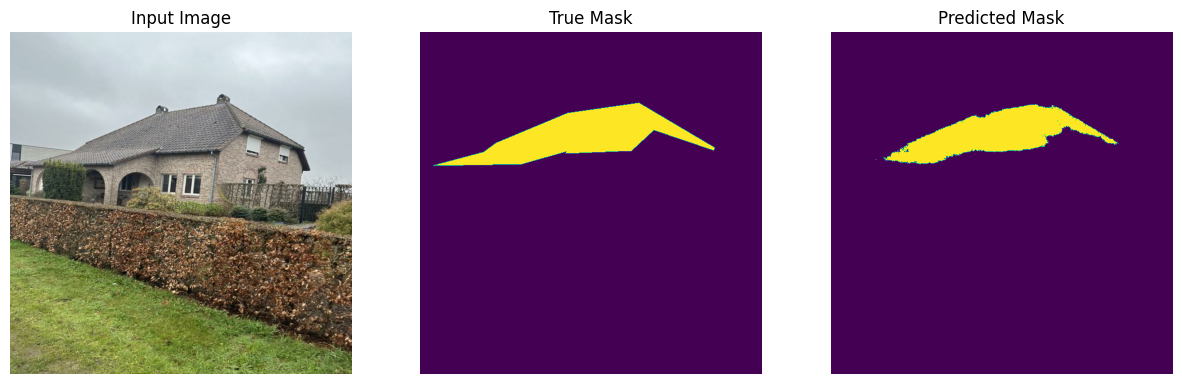

1/1 [==============================] - 0s 375ms/step


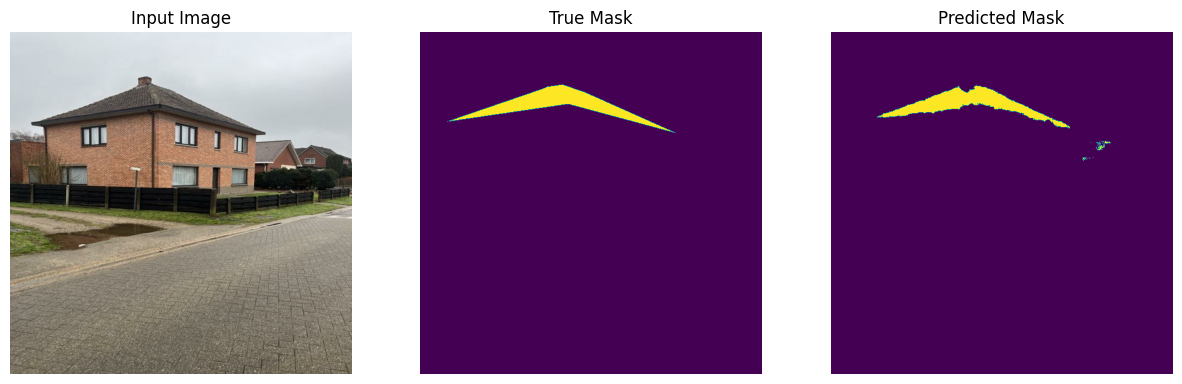

1/1 [==============================] - 0s 367ms/step


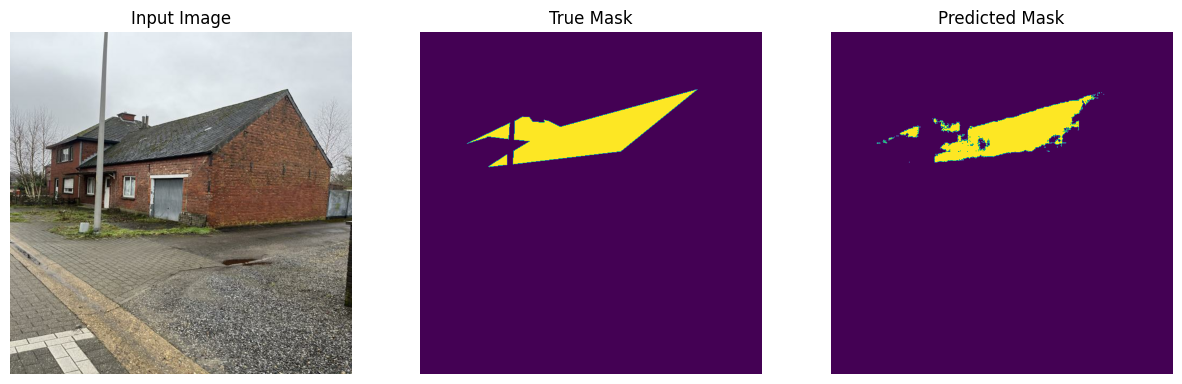

1/1 [==============================] - 0s 370ms/step


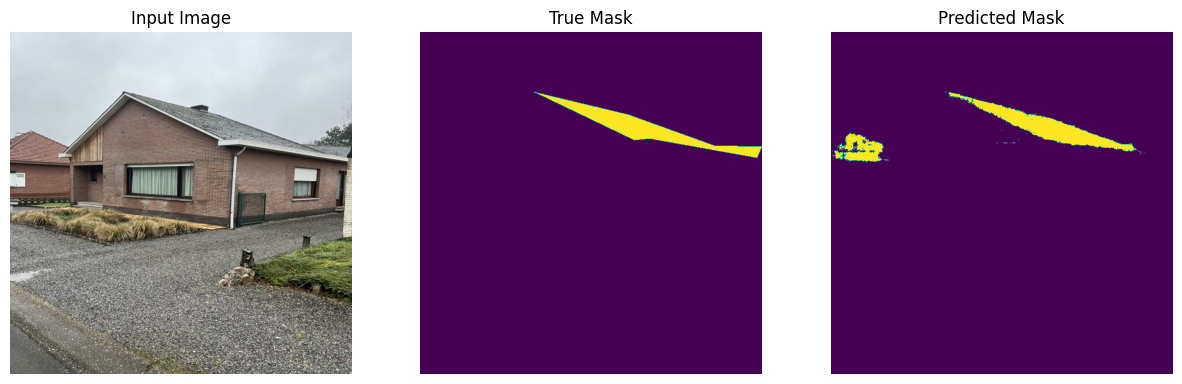

In [23]:
for image, mask in validation_images.take(5):
  sample_image, sample_mask = image, mask
  show_predictions()

In [24]:
model.save(f'models/{model_version}.keras')


In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile(f'models/{model_version}.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmpq2a6xlr8/assets


INFO:tensorflow:Assets written to: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmpq2a6xlr8/assets
2024-10-10 03:17:54.464243: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-10-10 03:17:54.464261: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-10-10 03:17:54.469027: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmpq2a6xlr8
2024-10-10 03:17:54.500659: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-10-10 03:17:54.500676: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmpq2a6xlr8
2024-10-10 03:17:54.562293: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-10-10 03:17:54.591088: I tensorflow/cc/saved_model/load